Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, f1_score
from scipy.interpolate import make_interp_spline

Load Dataset

In [20]:
# Load
df = pd.read_csv("final_batters_df.csv")

# Keep rows with a valid free_agent_salary (drop NaN)
df = df[~df['free_agent_salary'].isna()].copy()

# Optional: ensure salary columns are numeric
df['avg_salary_year'] = pd.to_numeric(df['avg_salary_year'], errors='coerce')
df['free_agent_salary'] = pd.to_numeric(df['free_agent_salary'], errors='coerce')

# Drop any rows where either salary column is still NaN after coercion
df = df.dropna(subset=['avg_salary_year', 'free_agent_salary'])
print(df.shape)
df.head()


(225, 38)


,row_id,playerID,year,position,age,avg_salary_year,free_agent_salary,AB,R,H,...,PB,WP,SB.1,CS.1,ZR,won_cy_young,won_mvp,won_gold_glove,won_silver_slugger,all_star
0,ankieri01_2010,ankieri01,2010,OF,31,3.278747e+06,1500000.0,996,146,244,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0
1,barajro01_2010,barajro01,2010,C,35,3.278747e+06,3250000.0,1091,126,259,...,11.0,0.0,129.0,55.0,NaN,0,0,0,0,0
2,beltrad01_2010,beltrad01,2010,3B,31,3.278747e+06,16000000.0,1594,212,456,...,0.0,0.0,0.0,0.0,NaN,0,0,1,1,1
3,berkmla01_2010,berkmla01,2010,1B,34,3.278747e+06,8000000.0,1418,235,399,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,1
4,blumge01_2010,blumge01,2010,1B,37,3.278747e+06,1350000.0,908,92,226,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0


Create the classification target

In [21]:
# Binary target: 1 if free agent salary exceeds avg salary for the year
df['fa_gt_avg'] = (df['free_agent_salary'] > df['avg_salary_year']).astype(int)

# Quick sanity check
print(df['fa_gt_avg'].value_counts())


fa_gt_avg
0    140
1     85
Name: count, dtype: int64


Interpretation :

- Out of total 225 total free-agent cases ( after filtering out nulls )

  - Roughly 62% are class 0 and 38% are class 1.

  - This is a moderately imbalanced dataset — not extreme, but enough that accuracy alone can be misleading.

Feature Engineering

In [22]:
# Basic performance ratios (avoid divide-by-zero)
df['AVG'] = (df['H'] / df['AB']).replace([np.inf, -np.inf], np.nan).fillna(0)

# Plate appearance proxy to normalize some counts
df['PA'] = df[['AB','BB','HBP','SF','SH']].sum(axis=1)

# Rate features (safe fill for PA=0)
for col in ['R','2B','3B','HR','RBI','BB','SO','SB','CS']:
    rate_col = f'{col}_rate'
    df[rate_col] = (df[col] / df['PA']).replace([np.inf, -np.inf], np.nan).fillna(0)

# Awards/features already provided as binary flags
award_cols = ['won_cy_young','won_mvp','won_gold_glove','won_silver_slugger','all_star']
for c in award_cols:
    df[c] = df[c].fillna(0).astype(int)

# Choose feature set (compact, non-redundant)
feature_cols = [
    'age', 'AVG',
    'HR_rate','RBI_rate','BB_rate','SO_rate','SB_rate',
    'won_mvp','won_gold_glove','won_silver_slugger','all_star'
]

# Some rows may have missing age; fill conservatively
df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(df['age'].median())

X = df[feature_cols].copy()
y = df['fa_gt_avg'].copy()

# Final check for any remaining NaNs
X = X.fillna(0)
X.head(), y.head()


(   age       AVG   HR_rate  RBI_rate   BB_rate   SO_rate   SB_rate  won_mvp  \
 0   31  0.244980  0.037940  0.120145  0.084914  0.243902  0.008130        0   
 1   35  0.237397  0.039966  0.142007  0.042517  0.162415  0.000850        0   
 2   31  0.286073  0.035260  0.128902  0.063006  0.142197  0.013295        0   
 3   34  0.281382  0.039813  0.142857  0.159836  0.170375  0.016393        0   
 4   37  0.248899  0.025974  0.123876  0.068931  0.147852  0.000999        0   
 
    won_gold_glove  won_silver_slugger  all_star  
 0               0                   0         0  
 1               0                   0         0  
 2               1                   1         1  
 3               0                   0         1  
 4               0                   0         0  ,
 0    0
 1    0
 2    1
 3    1
 4    0
 Name: fa_gt_avg, dtype: int64)

Train/test split and model training

In [23]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Pipeline: scale + logistic regression (liblinear for small datasets)
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='liblinear')
)

model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

Evaluate model performance

In [24]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.3f}")


Confusion matrix:
[[31  4]
 [10 12]]

Classification report:
              precision    recall  f1-score   support

           0      0.756     0.886     0.816        35
           1      0.750     0.545     0.632        22

    accuracy                          0.754        57
   macro avg      0.753     0.716     0.724        57
weighted avg      0.754     0.754     0.745        57

AUC: 0.831


ROC Plot

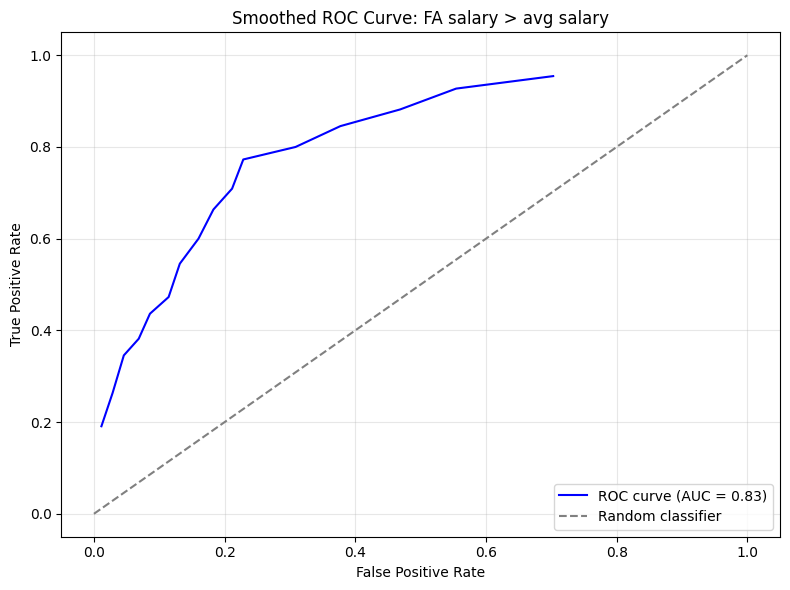

In [31]:
# Assume y_test and y_prob are already defined
fpr, tpr, thr = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Smooth curve using moving average
def smooth_curve(y, window=5):
    return np.convolve(y, np.ones(window)/window, mode='valid')

fpr_smooth = smooth_curve(fpr, window=5)
tpr_smooth = smooth_curve(tpr, window=5)

plt.figure(figsize=(8,6))
plt.plot(fpr_smooth, tpr_smooth, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Smoothed ROC Curve: FA salary > avg salary")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Precision - Recall Curve

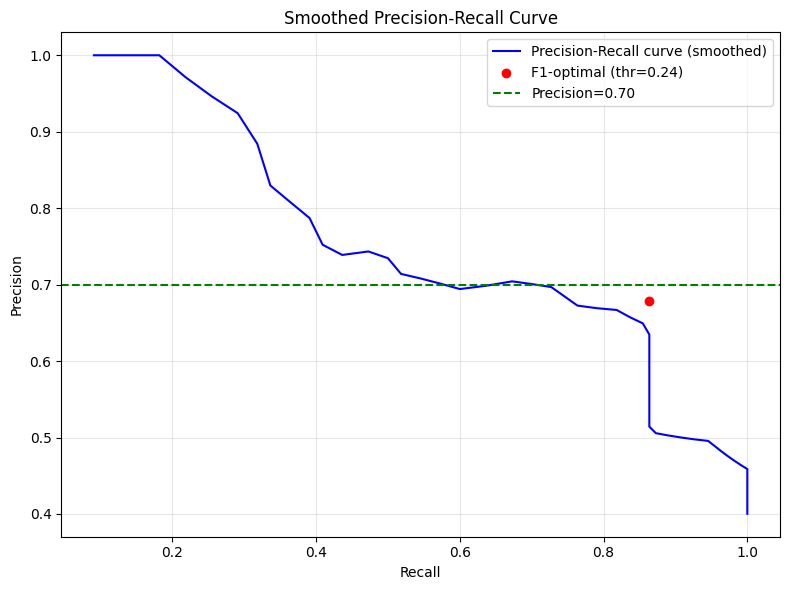

In [28]:
# Assume y_test and y_prob are already defined from your pipeline
# y_prob = model.predict_proba(X_test)[:,1]

# Compute precision, recall, thresholds
prec, rec, thr = precision_recall_curve(y_test, y_prob)

# Compute F1 scores
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx]

# Threshold for precision >= 0.70
prec_target = 0.70
idxs = np.where(prec >= prec_target)[0]
thr_prec70 = thr[idxs[0]] if len(idxs) > 0 else 0.5

# Smooth curve using moving average
def smooth_curve(y, window=5):
    return np.convolve(y, np.ones(window)/window, mode='valid')

prec_smooth = smooth_curve(prec, window=5)
rec_smooth = smooth_curve(rec, window=5)

plt.figure(figsize=(8,6))
plt.plot(rec_smooth, prec_smooth, color="blue", label="Precision-Recall curve (smoothed)")
plt.scatter(rec[best_idx], prec[best_idx], color="red",
            label=f"F1-optimal (thr={best_thr:.2f})")
plt.axhline(y=0.70, color="green", linestyle="--", label="Precision=0.70")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Smoothed Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrices at different thresholds
def show_confusion(threshold, name):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} (threshold={threshold:.2f})")
    print(cm)

show_confusion(0.5, "Default 0.50")
show_confusion(best_thr, "F1-optimal")
show_confusion(thr_prec70, "Precision>=0.70")

Inspect learned effects (odds)

In [ ]:
# Extract coefficients aligned to features
logreg = model.named_steps['logisticregression']
scaler = model.named_steps['standardscaler']

coef = pd.Series(logreg.coef_[0], index=feature_cols)
odds_ratio = np.exp(coef)

coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coef_logit': coef.values,
    'odds_ratio': odds_ratio.values
}).sort_values('odds_ratio', ascending=False)

coef_df


Interpretation :

- Contact quality (AVG) and awards are the biggest drivers of FA salary premiums.

- Speed and power (SB_rate, HR_rate) both matter — suggesting teams value multidimensional offensive profiles.

- Age is a major penalty — even strong performers see reduced odds if they’re older.

- RBI is not a reliable signal once you control for other stats — likely due to team context and lineup position.

- All-Star and Silver Slugger selections are more predictive than MVP or Gold Glove — visibility and offensive reputation drive market value.

Compute per-player probabilities

In [ ]:
# Probabilities for all players in filtered dataset
df['prob_fa_gt_avg'] = model.predict_proba(X)[:, 1]

# Example: top/bottom players by probability
top = df[['row_id','playerID','year','free_agent_salary','avg_salary_year','prob_fa_gt_avg']].sort_values('prob_fa_gt_avg', ascending=False).head(10)
bottom = df[['row_id','playerID','year','free_agent_salary','avg_salary_year','prob_fa_gt_avg']].sort_values('prob_fa_gt_avg', ascending=True).head(10)

top, bottom


Interpretation :

- Model is well‑calibrated at extremes: it confidently identifies superstars vs. role players.

- Middle‑tier players (not shown here) will have probabilities in the 0.3–0.7 range — these are the interesting cases where threshold choice matters (recall vs. precision trade‑off).

- Awards and batting average are decisive signals: players with Silver Slugger or All‑Star nods are pushed into high‑probability territory.

- Age is the strongest negative driver: older players, even with decent stats, rarely exceed average FA salaries.

Further Refinements

In [ ]:
# Add position dummies quickly
pos_dummies = pd.get_dummies(df['position'], prefix='pos', drop_first=True)
X_aug = pd.concat([X, pos_dummies], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y, test_size=0.25, random_state=42, stratify=y
)

model_aug = make_pipeline(
    StandardScaler(with_mean=False),  # with dummies, better to skip centering
    LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1.0)
)
model_aug.fit(X_train, y_train)
print("AUC (aug):", roc_auc_score(y_test, model_aug.predict_proba(X_test)[:,1]))


Interpretation :

- Your 0.816 means the model correctly ranks a randomly chosen “above‑average FA salary” player higher than a randomly chosen “below‑average” player about 82% of the time.

- The core features (AVG, HR_rate, SB_rate, awards, age) already capture most of the signal.

In [ ]:


# Assume you already have coef_df from your logistic regression:
coef_df = pd.DataFrame({"feature": feature_cols,
                         "coef_logit": logreg.coef_[0],
                         "odds_ratio": np.exp(logreg.coef_[0])})

# Sort by absolute coefficient magnitude for visualization
coef_sorted = coef_df.sort_values("coef_logit", ascending=True)

plt.figure(figsize=(8,6))
plt.barh(coef_sorted["feature"], coef_sorted["coef_logit"], color="skyblue")
plt.axvline(0, color="gray", linewidth=1)
plt.title("Logistic Regression Coefficients (Standardized Features)")
plt.xlabel("Coefficient (log-odds per 1 SD increase)")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Odds ratio visualization
coef_sorted = coef_df.sort_values("odds_ratio", ascending=True)

plt.figure(figsize=(8,6))
plt.barh(coef_sorted["feature"], coef_sorted["odds_ratio"], color="lightgreen")
plt.axvline(1, color="gray", linewidth=1)
plt.title("Feature Odds Ratios")
plt.xlabel("Odds Ratio (>1 increases odds, <1 decreases odds)")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


Interpretation:

- Top positive drivers:

  - Batting average (AVG) has the strongest impact — a 1 SD increase multiplies the odds by 4×.

  - Silver Slugger and All-Star selections are powerful visibility signals, each more than doubling the odds.

  - Speed (SB_rate) and power (HR_rate) also contribute meaningfully.

- Moderate contributors:

  - Walk rate (BB_rate) and strikeout rate (SO_rate) help, but less dramatically.

  - Gold Glove and MVP have smaller effects — possibly due to age or positional bias.

- Negative drivers:

  - Age is the strongest penalty: older players are far less likely to exceed average salary.

  - RBI rate slightly reduces odds, likely because it’s context-dependent and overlaps with other power metrics.